In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import collections
from collections import Counter
import statsmodels.api as sm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

pd.set_option('display.max_columns', 1000) 
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
supplier=pd.read_csv('SupplierData.csv')
content=pd.read_csv('ContentRecommendationData.csv')
module=pd.read_csv('ModuleCountData.csv')

In [ ]:
# step 1
supplier2=supplier[supplier.suid!=1]
supplier3=supplier2.groupby(['prsku','suid']).sum()
supplier3=supplier3.reset_index()

In [ ]:
modulesubset = module[['prsku', 'modulecount']]
dataCombine=pd.merge(supplier3, modulesubset, on='prsku',how='left')
dataCombine['modulecount']=dataCombine['modulecount'].fillna(0)
dataCombine['rev']=dataCombine.grs12month + dataCombine.expectedgrs
dataCombine['conversion']=dataCombine.placedorder / dataCombine.trafficcount

In [ ]:
suppliersubset = supplier[['prsku', 'clname', 'mkcname']].drop_duplicates()
dataCombine2 = pd.merge(dataCombine, suppliersubset, on='prsku', how='left')
dataCombine2

,prsku,suid,soid,clid,iswaymore,addedtocart,placedorder,trafficcount,iscurrent,videocount,grs1month,grs2month,grs3month,grs12month,weightedavgscore,percentilerank,expectedgrs,modulecount,rev,conversion,clname,mkcname
0,AAAQ1153,3358,6,42,0,1,0,273,1,0,0.000000,0.000000,0.000000,394.980480,0.00,0.00,0.0000,0.0,394.980480,0.000000,Cribs,Nursery
1,AABK1029,7080,8,36,0,25,8,473,1,0,687.020526,1777.937150,2947.461650,13091.901794,0.00,0.00,0.0000,0.0,13091.901794,0.016913,Mattress Toppers and Pads,Mattresses - Utility Bedding
2,AABK1029,8935,8,36,0,25,8,473,1,0,14.205562,19.644214,30.374502,1144.494274,0.00,0.00,0.0000,0.0,1144.494274,0.016913,Mattress Toppers and Pads,Mattresses - Utility Bedding
3,AABK1030,7080,8,36,0,39,8,719,1,0,659.448634,3100.487540,5660.724368,8399.134530,0.00,0.00,0.0000,0.0,8399.134530,0.011127,Mattress Toppers and Pads,Mattresses - Utility Bedding
4,AABK1030,8935,8,36,0,39,8,719,1,0,9.837852,9.837852,9.837852,9.837852,0.00,0.00,0.0000,0.0,9.837852,0.011127,Mattress Toppers and Pads,Mattresses - Utility Bedding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697079,ZZYZ1040,3456,14,48,0,0,0,384,2,0,0.000000,17865.174894,51274.151740,142052.578976,6.68,3.92,60755.2960,0.0,202807.874976,0.000000,Dining Table Sets,Furniture - Kitchen and Dining
697080,ZZYZ1052,3456,14,112,0,117,29,1995,2,0,2159.378746,5125.502410,5743.845072,6858.187784,0.00,0.00,0.0000,0.0,6858.187784,0.014536,Smokers,Fireplaces & Grills
697081,ZZYZ1053,3456,14,32,0,342,33,9548,2,0,11807.489722,22745.304022,37199.961316,73375.300586,6.68,3.96,165153.3632,0.0,238528.663786,0.003456,Kitchen Islands,Furniture - Kitchen and Dining
697082,ZZYZ1055,3456,14,148,0,16,2,261,2,0,173.527914,509.726028,805.666330,2404.622276,6.20,3.84,35602.3416,0.0,38006.963876,0.007663,Bathroom Storage,Storage and Org


In [ ]:
dataCombine3 = dataCombine2[['clname','modulecount','rev']]
dataCombine4 = dataCombine2[['clname','modulecount','conversion']]
classdata_rev = dataCombine3.groupby('clname').mean(['modulecount','rev']).sort_values(['modulecount','rev'])
classdata_cr = dataCombine4.groupby('clname').mean(['modulecount','conversion']).sort_values(['modulecount','conversion'])

Text(0, 0.5, 'WCSS')

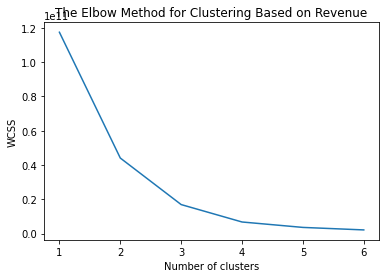

In [ ]:
# clustering based on revenue
x_rev = classdata_rev.iloc[:,0:3]
wcss_rev=[]
for i in range(1,7):
  kmeans_rev = KMeans(i)
  kmeans_rev.fit(x_rev)
  wcss_iter_rev = kmeans_rev.inertia_
  wcss_rev.append(wcss_iter_rev)

# use Elbow Method to find the best number of clusters
number_clusters = range(1,7)
plt.plot(number_clusters,wcss_rev)
plt.title('The Elbow Method for Clustering Based on Revenue')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

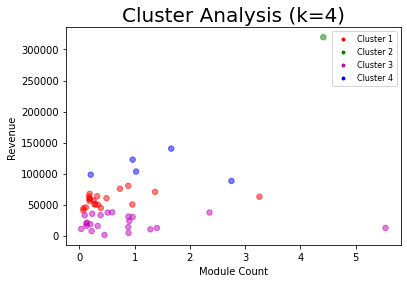

In [ ]:
# graph when k=4
classdata4 = classdata_rev
kmeans = KMeans(n_clusters=4, random_state=0)
classdata4['cluster'] = kmeans.fit_predict(classdata4[['modulecount','rev']])
cen_x = [i[0] for i in centers] 
cen_y = [i[1] for i in centers]
## add to df
classdata4['cen_x'] = classdata4.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
classdata4['cen_y'] = classdata4.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
colors = ['r', 'g', 'm', 'b']
classdata4['c'] = classdata4.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
                          markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

plt.legend(handles=legend_elements, loc='upper right', fontsize=8)
plt.title('Cluster Analysis (k=4)', loc='center', fontsize=20)
plt.xlabel('Module Count')
plt.ylabel('Revenue')
plt.scatter(classdata4.modulecount, classdata4.rev, c=classdata4.c, alpha = 0.5, s=30) 

In [ ]:
# find the indices of product classes that belong to each cluster
mydict_rev = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
mydict_rev

{0: array([ 1,  2,  4,  8,  9, 10, 11, 12, 17, 18, 19, 20, 22, 24, 26, 29, 30,
        35, 40, 45]),
 1: array([46]),
 2: array([ 0,  3,  5,  6,  7, 13, 15, 16, 21, 23, 25, 27, 28, 31, 32, 33, 34,
        36, 39, 41, 43, 47]),
 3: array([14, 37, 38, 42, 44])}

In [ ]:
# target cluster is the one with less revenue and fewer modules on average
# extract the corresponding product classes
targetcluster_rev = classdata_rev.iloc[[0,  3,  5,  6,  7, 13, 15, 16, 21, 23, 25, 27, 28, 31, 32, 33, 34,
        36, 39, 41, 43, 47]]
targetcluster_rev

,modulecount,rev,cluster,cen_x,cen_y,c
clname,,,,,,
Bedding Sets,0.030464,10717.328400,2,4.978426,0.009363,m
Reception Seating Chairs,0.094675,32651.576664,2,4.978426,0.009363,m
Chandeliers,0.125637,19494.877649,2,4.978426,0.009363,m
End Tables,0.125922,15517.332643,2,4.978426,0.009363,m
Interior Doors,0.135175,20899.173861,2,4.978426,0.009363,m
Bathroom Storage,0.197640,18164.474217,2,4.978426,0.009363,m
Electric Grills,0.220339,7224.013133,2,4.978426,0.009363,m
Accent Chests / Cabinets,0.230726,35112.698516,2,4.978426,0.009363,m
Tubs And Whirlpools,0.329377,15517.915710,2,4.978426,0.009363,m


Text(0, 0.5, 'WCSS')

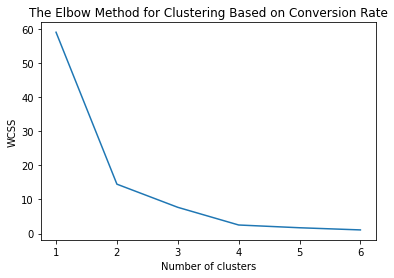

In [ ]:
# clustering based on conversion
x_cr = classdata_cr.iloc[:,0:3]
wcss_cr=[]
for i in range(1,7):
  kmeans_cr = KMeans(i)
  kmeans_cr.fit(x_cr)
  wcss_iter_cr = kmeans_cr.inertia_
  wcss_cr.append(wcss_iter_cr)

# use Elbow Method to find the best number of clusters
number_clusters = range(1,7)
plt.plot(number_clusters,wcss_cr)
plt.title('The Elbow Method for Clustering Based on Conversion Rate')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

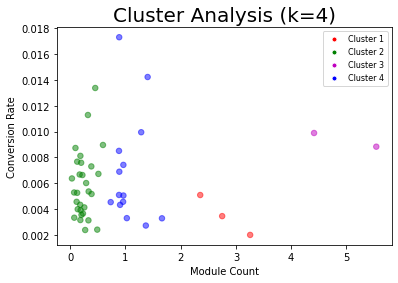

In [ ]:
# graph when k=4
classdata4_cr = classdata_cr
kmeans_cr = KMeans(n_clusters=4, random_state=0)
classdata4_cr['cluster'] = kmeans_cr.fit_predict(classdata4_cr[['modulecount','conversion']])
cen_x_cr = [i[0] for i in centers] 
cen_y_cr = [i[1] for i in centers]
## add to df
classdata4_cr['cen_x_cr'] = classdata4_cr.cluster.map({0:cen_x_cr[0], 1:cen_x_cr[1], 2:cen_x_cr[2], 3:cen_x_cr[3]})
classdata4_cr['cen_y_cr'] = classdata4_cr.cluster.map({0:cen_y_cr[0], 1:cen_y_cr[1], 2:cen_y_cr[2], 3:cen_y_cr[3]})
colors = ['r', 'g', 'm', 'b']
classdata4_cr['c'] = classdata4_cr.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

legend_elements_cr = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
                          markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

plt.legend(handles=legend_elements_cr, loc='upper right', fontsize=8)
plt.title('Cluster Analysis (k=4)', loc='center', fontsize=20)
plt.xlabel('Module Count')
plt.ylabel('Conversion Rate')
plt.scatter(classdata4_cr.modulecount, classdata4_cr.conversion, c=classdata4_cr.c, alpha = 0.5, s=30) 

In [ ]:
# find the indices of product classes that belong to each cluster
mydict_cr = {i: np.where(kmeans_cr.labels_ == i)[0] for i in range(kmeans_cr.n_clusters)}
mydict_cr

{0: array([43, 44, 45]),
 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 2: array([46, 47]),
 3: array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])}

In [ ]:
# target cluster is the one with lower conversion rate and fewer modules on average
# extract the corresponding product classes
targetcluster_cr = classdata_cr.iloc[[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
targetcluster_cr

,modulecount,conversion,cluster,cen_x_cr,cen_y_cr,c
clname,,,,,,
Bedding Sets,0.030464,0.006377,1,2.787624,0.003522,g
Dressers & Chests,0.070402,0.005291,1,2.787624,0.003522,g
Dining Table Sets,0.073076,0.003342,1,2.787624,0.003522,g
Reception Seating Chairs,0.094675,0.008734,1,2.787624,0.003522,g
Pantry Cabinets,0.115479,0.004572,1,2.787624,0.003522,g
Chandeliers,0.125637,0.005265,1,2.787624,0.003522,g
End Tables,0.125922,0.007675,1,2.787624,0.003522,g
Interior Doors,0.135175,0.003995,1,2.787624,0.003522,g
Kids Dressers & Chests,0.170300,0.006683,1,2.787624,0.003522,g


In [ ]:
# 13 product classes in common
# step 3
# select Filing Cabinets (clid=6) as example 1
cabinets = dataCombine2[dataCombine2.clid==6]
# find the recommended content types for products in Filing Cabinets
cabinets_sku = cabinets[['prsku']]
cabinets_content = pd.merge(cabinets_sku, content, on='prsku',how='left').biccontenttypename
#cabinetss_content.isnull().sum()

In [ ]:
cabinets_ccount = pd.DataFrame.from_dict(Counter(cabinets_content), orient='index').reset_index()
cabinets_ccount = cabinets_ccount.rename(columns={'index':'contenttype', 0:'count'})
cabinets_ccount = cabinets_ccount.dropna().sort_values('count', ascending=False)

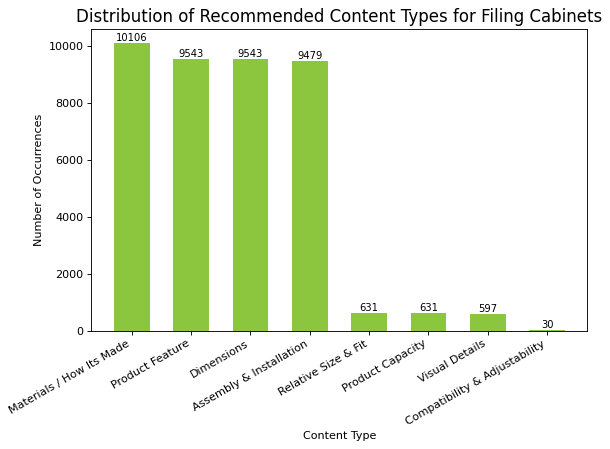

In [ ]:
figure(figsize=(8, 5), dpi=80)
x_pos_cc=range(len(cabinets_ccount))
plt.bar(x_pos_cc, cabinets_ccount['count'], width=0.6, color='#8cc63f')
plt.xticks(x_pos_cc, labels=cabinets_ccount.contenttype, rotation=30, ha='right', fontsize=10)
plt.title('Distribution of Recommended Content Types for Filing Cabinets', fontsize=15)
plt.xlabel('Content Type')
plt.ylabel('Number of Occurrences')
# add label on the bar chart
for pos, number in zip(x_pos_cc, cabinets_ccount['count']):
    plt.annotate(str(number), (pos,number), ha='center', va='bottom',fontsize=9)
plt.show()
# recommend materials/how it's made, product feature, dimensions, assembly & installation

In [ ]:
# step 4
# target suppliers with regard to filing cabinets
cabinets_supplier = cabinets[cabinets.suid.isin(list(cabinets.suid))]
csupplier_production=cabinets_supplier.groupby('suid').count()['prsku']
csupplier_production=pd.DataFrame(csupplier_production).reset_index(drop=False)
csupplier_production=csupplier_production.rename(columns={'prsku':'count'}).sort_values('count', ascending=False)
cabinets_top10=csupplier_production.iloc[:10,:]

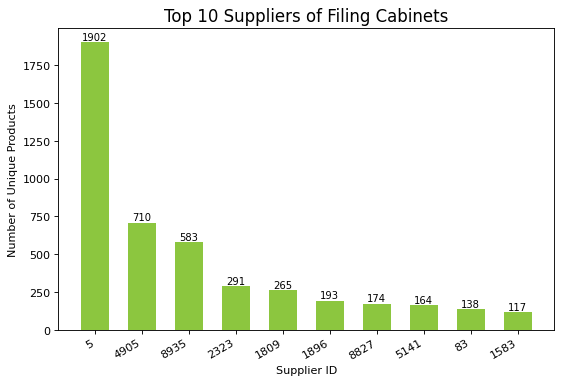

In [ ]:
figure(figsize=(8, 5), dpi=80)
x_pos_cs=range(len(cabinets_top10))
plt.bar(x_pos_cs, cabinets_top10['count'], width=0.6, color='#8cc63f')
plt.xticks(x_pos_cs, labels=cabinets_top10.suid, rotation=30, ha='right', fontsize=10)
plt.title('Top 10 Suppliers of Filing Cabinets', fontsize=15)
plt.xlabel('Supplier ID')
plt.ylabel('Number of Unique Products')
#add label on the bar chart
for pos, number in zip(x_pos_cs, cabinets_top10['count']):
    plt.annotate(str(number), (pos,number), ha='center', va='bottom',fontsize=9)
plt.show()

In [ ]:
#########################
# select Chandeliers (clid=38) as example 2
chandeliers = dataCombine2[dataCombine2.clid==38]
# find the recommended content types for products in chandeliers
chandeliers_sku = chandeliers[['prsku']]
chandeliers_content = pd.merge(chandeliers_sku, content, on='prsku',how='left').biccontenttypename
#chandeliers_content.isnull().sum()

In [ ]:
chandeliers_ccount = pd.DataFrame.from_dict(Counter(chandeliers_content), orient='index').reset_index()
chandeliers_ccount = chandeliers_ccount.rename(columns={'index':'contenttype', 0:'count'})
chandeliers_ccount = chandeliers_ccount.dropna().sort_values('count', ascending=False)
chandeliers_ccount

,contenttype,count
3,Dimensions,12559
0,Touch & Feel,12300
1,Cleaning & Care,12300
2,Materials / How Its Made,12300
5,Assembly & Installation,259
6,Product Feature,259
7,Visual Details,259


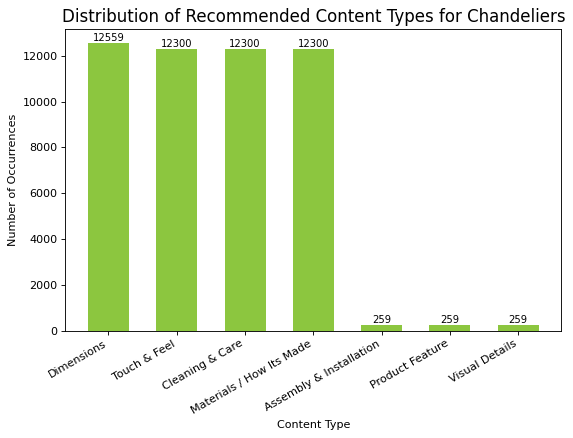

In [ ]:
figure(figsize=(8, 5), dpi=80)
x_pos_chc=range(len(chandeliers_ccount))
plt.bar(x_pos_chc, chandeliers_ccount['count'], width=0.6, color='#8cc63f')
plt.xticks(x_pos_chc, labels=chandeliers_ccount.contenttype, rotation=30, ha='right', fontsize=10)
plt.title('Distribution of Recommended Content Types for Chandeliers', fontsize=15)
plt.xlabel('Content Type')
plt.ylabel('Number of Occurrences')
# add label on the bar chart
for pos, number in zip(x_pos_chc, chandeliers_ccount['count']):
    plt.annotate(str(number), (pos,number), ha='center', va='bottom',fontsize=9)
plt.show()
# recommend dimensions, touch & feel, cleaning & care, materials/how it's made

In [ ]:
# step 4
# target suppliers with regard to chandeliers
chandeliers_supplier = chandeliers[chandeliers.suid.isin(list(chandeliers.suid))]
chsupplier_production=chandeliers_supplier.groupby('suid').count()['prsku']
chsupplier_production=pd.DataFrame(chsupplier_production).reset_index(drop=False)
chsupplier_production=chsupplier_production.rename(columns={'prsku':'count'}).sort_values('count', ascending=False)
chsupplier_top10=chsupplier_production.iloc[:10,:]

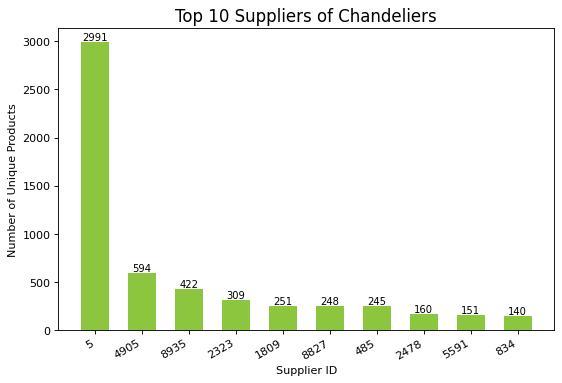

In [ ]:
figure(figsize=(8, 5), dpi=80)
x_pos_chs=range(len(chsupplier_top10))
plt.bar(x_pos_chs, chsupplier_top10['count'], width=0.6, color='#8cc63f')
plt.xticks(x_pos_chs, labels=chsupplier_top10.suid, rotation=30, ha='right', fontsize=10)
plt.title('Top 10 Suppliers of Chandeliers', fontsize=15)
plt.xlabel('Supplier ID')
plt.ylabel('Number of Unique Products')
#add label on the bar chart
for pos, number in zip(x_pos_chs, chsupplier_top10['count']):
    plt.annotate(str(number), (pos,number), ha='center', va='bottom',fontsize=9)
plt.show()